In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

- 전처리 된 데이터 프레임 불러오기

In [5]:
PROCESSED_DIR = os.path.join('..', '전처리완료')

df_customers = pd.read_parquet(os.path.join(PROCESSED_DIR, 'customers_clean.parquet'))
df_articles = pd.read_parquet(os.path.join(PROCESSED_DIR, 'articles_clean.parquet'))
df_transactions = pd.read_parquet(os.path.join(PROCESSED_DIR, 'transactions_clean.parquet'))

print("---" * 15)
print(" 전처리 된 데이터 불러오기 성공")

---------------------------------------------
 전처리 된 데이터 불러오기 성공


- 폰트 깨짐 방지

In [6]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스 전용 코드
    plt.rc('font', family='NanumGothic')

# 마이너스 기호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

- 테이블 조인 (필요한 컬럼만 가져와야 메모리 효율이 높음)

In [7]:

df_merged = pd.merge(df_transactions[['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']], 
                     df_customers[['customer_id', 'age_group_biz']], 
                     on='customer_id', how='inner')

df_merged = pd.merge(df_merged, 
                     df_articles[['article_id', 'prod_name', 'product_group_name', 'graphical_appearance_name', 'index_group_name']], 
                     on='article_id', how='left')

# 2. 장바구니(Basket) 정의: 같은 날짜 + 같은 고객

# basket_size ----> 장바구니에 담긴 상품 개수
basket_df = df_merged.groupby(['t_dat', 'customer_id']).agg({
    'article_id': 'count',
    'age_group_biz': 'first' 
}).reset_index()

basket_df.rename(columns={'article_id': 'basket_size'}, inplace=True)

# 3. 단품(Single) vs 다품(Multi) 라벨링까지
basket_df['type'] = basket_df['basket_size'].apply(lambda x: 'Single (1개)' if x == 1 else 'Multi (2개 이상)')

print("✅ 분석 준비 완료!")

✅ 분석 준비 완료!


- WHO 누가 1개만 사는가?

<Figure size 1200x600 with 0 Axes>

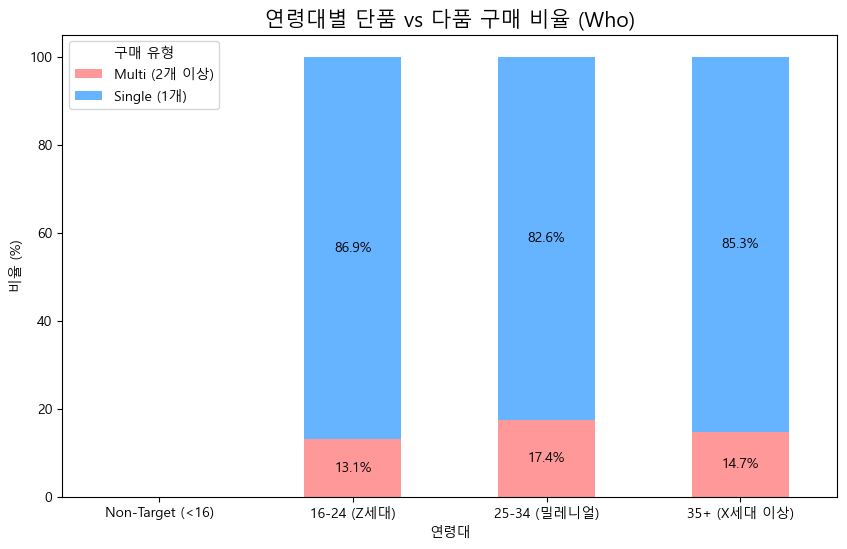

In [8]:
# 1. 연령대별 단품/다품 비율 계산
age_basket_counts = basket_df.groupby(['age_group_biz', 'type'], observed=False).size().unstack(fill_value=0)

# 2. 비율(%)로 변환 (각 연령대별 합이 100%가 되도록)
age_basket_ratio = age_basket_counts.div(age_basket_counts.sum(axis=1), axis=0) * 100

# 3. 시각화 --> Bar 차트
plt.figure(figsize=(12, 6))
ax = age_basket_ratio.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(10, 6))

plt.title("연령대별 단품 vs 다품 구매 비율 (Who)", fontsize=15)
plt.ylabel("비율 (%)")
plt.xlabel("연령대")
plt.legend(title='구매 유형', loc='upper left')
plt.xticks(rotation=0)

# 비율 숫자 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0: 
        ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center')

plt.show()

그래서 나온 결과는?

- 그래프를 보면, 25-34세 그룹이 17.4%로 다품 구매 비율이 가장 높고, 16-24세 그룹이 86.9%로 단품 구매 비율이 가장 높다.

- 뭔가 크게 의미있는 인사이트는 아니고 거진 대부분이 단품 구매 고객임


- What 어떤 상품이 '혼자' 팔리는가?

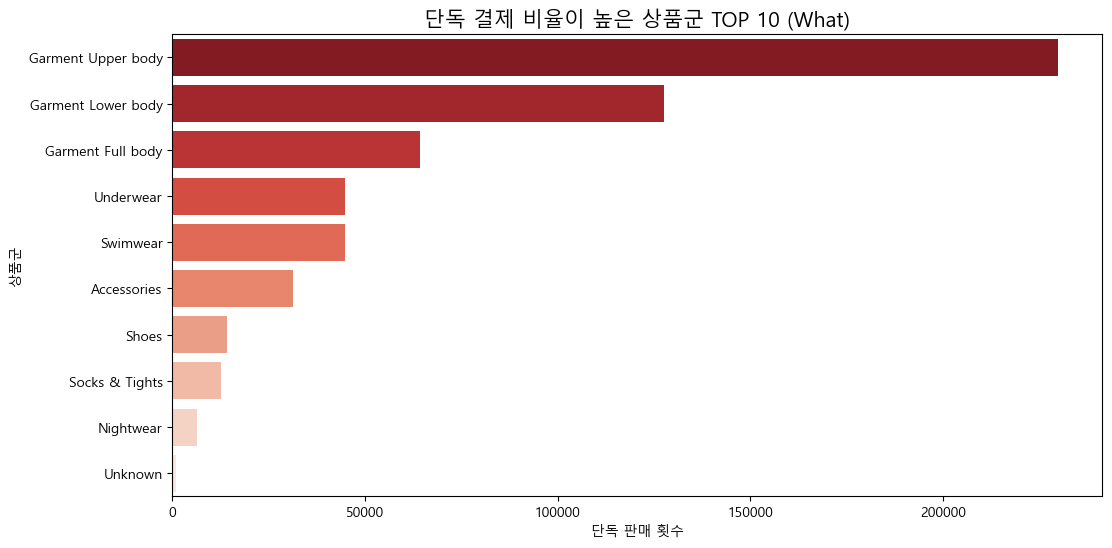

In [9]:
# 1. '단품 구매' 거래만 필터링
single_baskets = basket_df[basket_df['type'] == 'Single (1개)']
single_transactions = df_merged[df_merged.set_index(['t_dat', 'customer_id']).index.isin(single_baskets.set_index(['t_dat', 'customer_id']).index)]

# 2. 상품 그룹별 단독 판매 횟수 집계 --> 상위 10개만
top_lonely_items = single_transactions['product_group_name'].value_counts().head(10)

# 3. 시각화
df_lonely_plot = top_lonely_items.reset_index()

# 컬럼 이름을 명확히 지정해줍니다.
df_lonely_plot.columns = ['상품군', '단독 판매 횟수']
plt.figure(figsize=(12, 6))
sns.barplot(x='단독 판매 횟수', y='상품군', 
            data=df_lonely_plot,      
            hue='상품군',             
            palette='Reds_r', 
            legend=False)

plt.title("단독 결제 비율이 높은 상품군 TOP 10 (What)", fontsize=15)
plt.xlabel("단독 판매 횟수")
plt.ylabel("상품군")
plt.show()

그래서 나온 결과는?

- 그래프를 보면, 막대 길이가 '상의(Garment Upper body)'와 하의(Garment Lower body)'에서 압도적으로 길게 나타남

- 이 결과는 고객들이 H&M의 핵심 상품인 옷(상의/하의)을 살 때도 대부분 '단 하나만' 사고 있다는 것을 증명함

- How: 무엇을 '같이' 사는가? (히트맵)

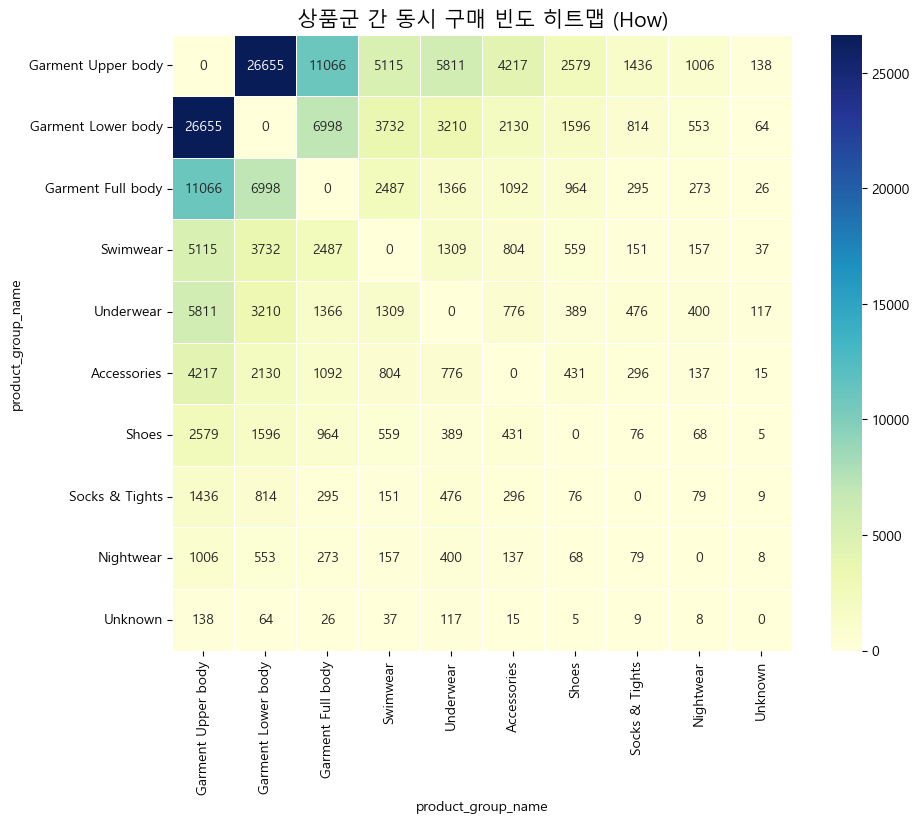

In [10]:
# 1. '다품 구매' 거래만 필터링
multi_baskets = basket_df[basket_df['type'] == 'Multi (2개 이상)']
multi_transactions = df_merged[df_merged.set_index(['t_dat', 'customer_id']).index.isin(multi_baskets.set_index(['t_dat', 'customer_id']).index)]

# 2. 같은 영수증 내 상품 조합 찾기
basket_items = multi_transactions[['t_dat', 'customer_id', 'product_group_name']]

# 같은 장바구니의 상품들을 리스트로 묶기 -> 자체 merge 기능이 있음

# 같은 Basket ID를 가진 상품끼리 결합
pairs = pd.merge(basket_items, basket_items, on=['t_dat', 'customer_id'])

pairs = pairs[pairs['product_group_name_x'] != pairs['product_group_name_y']]

# 3. 히트맵 데이터 생성 --> Pivot을 돌려서??
heatmap_data = pd.crosstab(pairs['product_group_name_x'], pairs['product_group_name_y'])

# 상위 10개만 필터링
top_10_groups = multi_transactions['product_group_name'].value_counts().head(10).index
heatmap_data_top = heatmap_data.loc[top_10_groups, top_10_groups]

# 4. 시각화 ---> 히트맵으로
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_top, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title("상품군 간 동시 구매 빈도 히트맵 (How)", fontsize=15)
plt.show()

최대 빈도수: 26,655건

- 해당 조합: Garment Upper body (상의류)와 Garment Lower body (하의류)의 교차점.

- 이 수치는 다품 구매 고객들이 '상의'**를 살 때 '하의'를 함께 사는 것이 가장 빈번한 쇼핑 패턴임을 의미합니다.

- 결론 도출 (우리의 최종결론은 연령대로 나눈 세 그룹에게 각각 세트상품을 추천해주는 전략)

In [11]:
target_segment = '16-24 (Z세대)' 

df_20s = df_merged[df_merged['age_group_biz'] == target_segment].copy()

print(f"1. 타겟({target_segment}) 데이터 추출 완료: 총 {len(df_20s):,}건")

# 20대 중에서 '단품 구매(Basket Size == 1)'한 영수증 ID만 찾기
single_basket_ids = basket_df[
    (basket_df['basket_size'] == 1) & 
    (basket_df['customer_id'].isin(df_20s['customer_id']))
]['customer_id'] 

single_purchases = pd.merge(
    df_20s, 
    basket_df[basket_df['basket_size'] == 1][['t_dat', 'customer_id']], 
    on=['t_dat', 'customer_id'], 
    how='inner'
)

# 가장 많이 팔린 상품 1위 찾기
top_product_A = single_purchases['prod_name'].value_counts().idxmax()
count_A = single_purchases['prod_name'].value_counts().max()

print(f"2. 20대가 가장 많이 산 단품(Product A): '{top_product_A}' ({count_A}회 구매)")



# 3. Product B 찾기 (A와 함께 산 짝꿍템)
# 20대 중에서 '다품 구매(Basket Size > 1)'한 내역 가져오기
multi_purchases = pd.merge(
    df_20s, 
    basket_df[basket_df['basket_size'] > 1][['t_dat', 'customer_id']], 
    on=['t_dat', 'customer_id'], 
    how='inner'
)

# 'Product A'가 포함된 장바구니(영수증)만 찾기
baskets_with_A = multi_purchases[multi_purchases['prod_name'] == top_product_A][['t_dat', 'customer_id']]

# 그 장바구니들에 들어있던 '모든 상품' 가져오기
associated_items = pd.merge(multi_purchases, baskets_with_A, on=['t_dat', 'customer_id'])

# A(자기 자신)는 제외하고, 가장 많이 등장한 상품(B) 찾기
product_B_candidates = associated_items[associated_items['prod_name'] != top_product_A]
top_product_B = product_B_candidates['prod_name'].value_counts().idxmax()
count_B = product_B_candidates['prod_name'].value_counts().max()

print(f" 3. '{top_product_A}'와 가장 많이 함께 구매된 짝꿍(Product B): '{top_product_B}' ({count_B}회 동반 구매)")

print("\n" + "="*50)
print(f" [최종 결론] {target_segment} 고객에게 '{top_product_A}' 구매 시 '{top_product_B}'를 추천")
print("="*50)

1. 타겟(16-24 (Z세대)) 데이터 추출 완료: 총 157,807건
2. 20대가 가장 많이 산 단품(Product A): 'Jade HW Skinny Denim TRS' (1108회 구매)
 3. 'Jade HW Skinny Denim TRS'와 가장 많이 함께 구매된 짝꿍(Product B): 'Julia RW Skinny Denim TRS' (10회 동반 구매)

 [최종 결론] 16-24 (Z세대) 고객에게 'Jade HW Skinny Denim TRS' 구매 시 'Julia RW Skinny Denim TRS'를 추천


C:\Users\urina\AppData\Local\Temp\ipykernel_25292\1309812262.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_partners.values, y=top_partners.index, palette=colors)


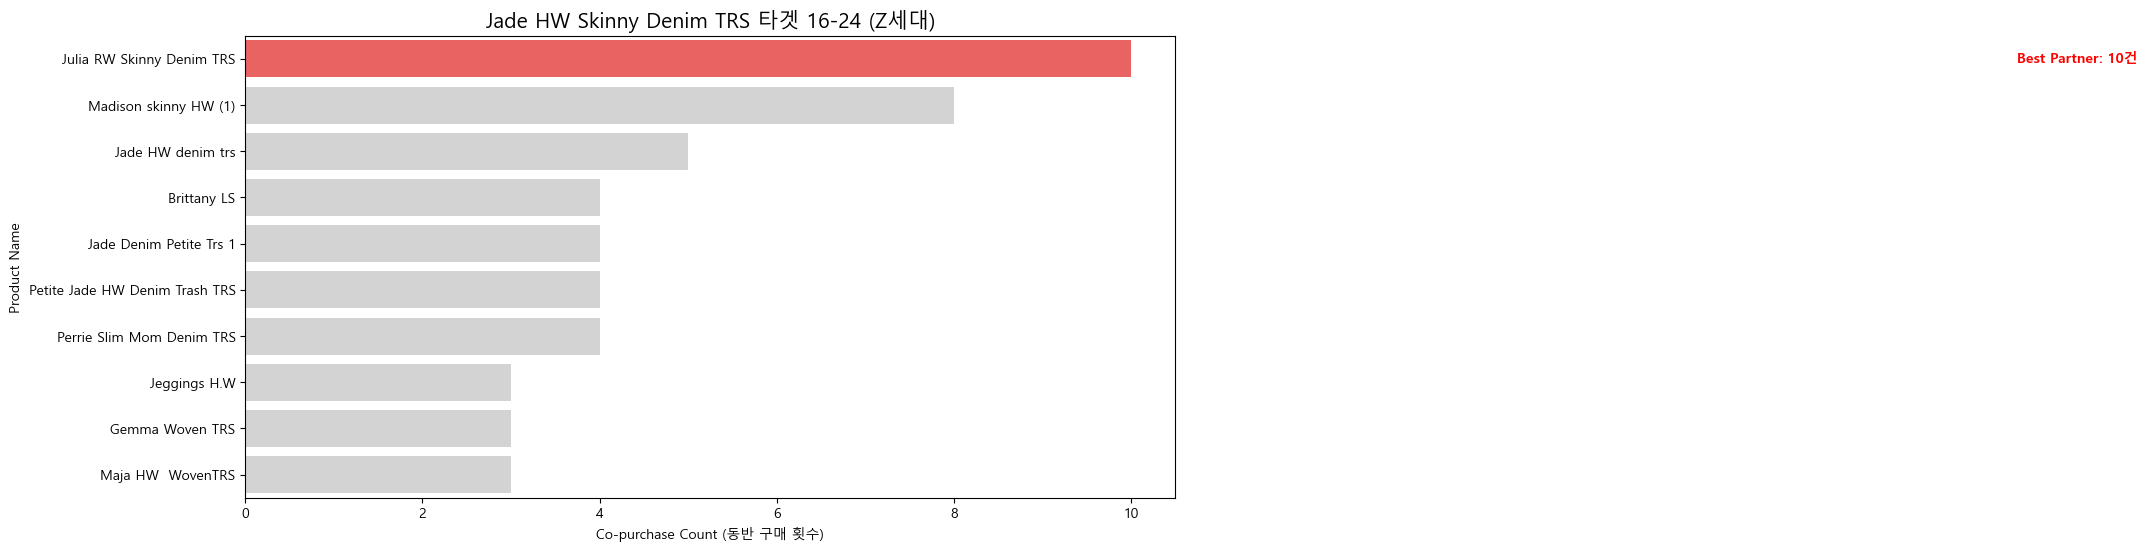

In [12]:
top_partners = associated_items[associated_items['prod_name'] != top_product_A]['prod_name'].value_counts().head(10)

# 2. 시각화 (Bar Chart)
plt.figure(figsize=(12, 6))

colors = ['#ff4d4d' if x == top_partners.index[0] else '#d3d3d3' for x in top_partners.index]

sns.barplot(x=top_partners.values, y=top_partners.index, palette=colors)

plt.title(f"{top_product_A} 타겟 {target_segment}", fontsize=15)
plt.xlabel("Co-purchase Count (동반 구매 횟수)")
plt.ylabel("Product Name")

# 1위 막대에 숫자 표시
for i, v in enumerate(top_partners.values):
    if i == 0: # 1등만 표시
        plt.text(v + 10, i, f"Best Partner: {v}건", color='red', fontweight='bold', va='center')

plt.show()

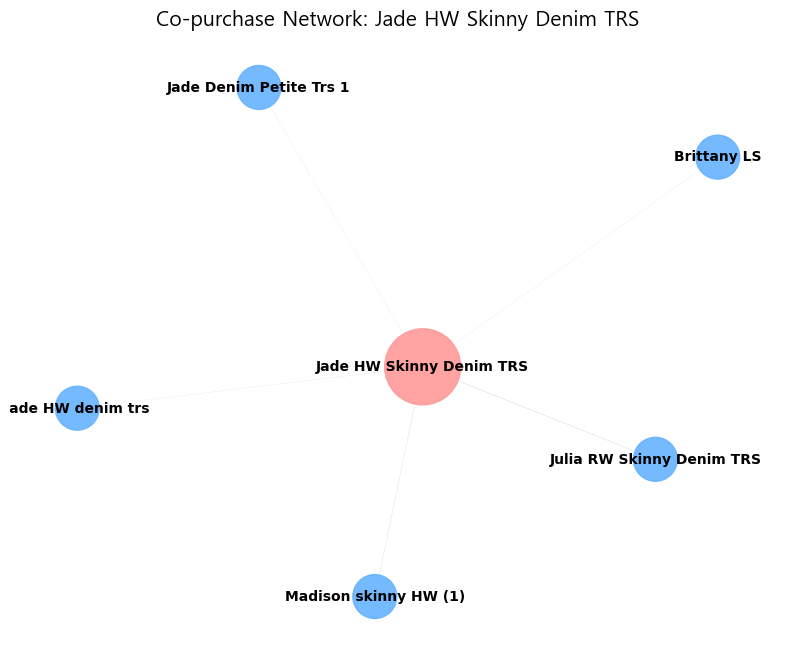

In [ ]:
import networkx as nx

# 1. 네트워크 데이터 준비 상위 5개만
top_5_partners = top_partners.head(5)
edges = [(top_product_A, partner, count) for partner, count in top_5_partners.items()]

# 2. 그래프 생성
G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# 3. 시각화 설정
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42) 

# 노드(상품) 그리기 - 중심(A)은 크게, 나머지는 작게
node_sizes = [3000 if node == top_product_A else 1000 for node in G.nodes()]
node_colors = ['#ff9999' if node == top_product_A else '#66b3ff' for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# 엣지(연결선) 그리기 - 동반 구매 횟수가 많을수록 굵게
weights = [G[u][v]['weight'] / 50 for u, v in G.edges()] 
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.5)

# 라벨 그리기
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title(f"Co-purchase Network: {top_product_A}", fontsize=15)
plt.axis('off') # 축은 숨김
plt.show()